In [4]:
import requests
import urllib3
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import time
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
#import stravalib

import polyline

import folium

pd.set_option("display.max_columns", 100)


Interesting link: https://towardsdatascience.com/using-the-strava-api-and-pandas-to-explore-your-activity-data-d94901d9bfde
Strava API forum: https://groups.google.com/g/strava-api

In [5]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
payload = {
    'client_id': "75483",
    'client_secret': 'd7d1e5483201559ddf62c677ac12f6cf7847c5ae',
    'refresh_token': '75994cf8182a3b6a956390b5a4da3eba764f1d85',
    'grant_type': "refresh_token",
    'f': 'json',
}

In [6]:
print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

Requesting Token...

Access Token = b3cf17818d406b57ee795c978b8918c84271e4ac



In [7]:
activites_url = "https://www.strava.com/api/v3/athlete/activities"

dataset=[]
pages_count=1

while pages_count>0:
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': pages_count}
    my_dataset=requests.get(activites_url, headers=header, params=param).json()
    if my_dataset==[]:
        break
    elif my_dataset!=[]:
        dataset.append(my_dataset)
        pages_count+=1
dataset = [j for i in dataset for j in i]


In [12]:
activities = pd.json_normalize(dataset)
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   resource_state                 461 non-null    int64  
 1   name                           461 non-null    object 
 2   distance                       461 non-null    float64
 3   moving_time                    461 non-null    int64  
 4   elapsed_time                   461 non-null    int64  
 5   total_elevation_gain           461 non-null    float64
 6   type                           461 non-null    object 
 7   workout_type                   157 non-null    float64
 8   id                             461 non-null    int64  
 9   start_date                     461 non-null    object 
 10  start_date_local               461 non-null    object 
 11  timezone                       461 non-null    object 
 12  utc_offset                     461 non-null    flo

In [13]:
#Create new dataframe with only columns I care about
cols =['name',
          'start_date_local',
          'id',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latlng',
          'map.summary_polyline']

activities = activities[cols]
"""
# Convert dates to datetime type
activities['start_date_local']= [datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in activities['start_date_local']]
activities['start_time']=[time(hour=i.hour,minute=i.minute,second=i.second) for i in activities['start_date_local']]
activities['start_date_local'] =[date(year=i.year,month=i.month,day=i.day) for i in activities['start_date_local']]
"""
# Create a distance in km column
activities['distance_km'] = activities['distance']/1000

# Convert dates to datetime type
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])

# Create a day of the week and month of the year columns
activities['day_of_week'] = activities['start_date_local'].dt.day_name()
activities['month_of_year'] = activities['start_date_local'].dt.month
# Convert times to timedeltas
activities['moving_time'] = pd.to_timedelta(activities['moving_time'])
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'])
# Convert timings to hours for plotting
activities['elapsed_time_hr'] = activities['elapsed_time'].view(int)/3600
activities['moving_time_hr'] = activities['moving_time'].view(int)/3600

activities.head()

,name,start_date_local,id,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latlng,map.summary_polyline,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,Afternoon Run,2022-04-11 17:38:54+00:00,6965765652,Run,17071.1,0 days 00:00:00.000005450,0 days 00:00:00.000005589,181.6,694.4,593.1,3.132,3.952,159.9,181.0,"[40.39984239265323, -3.7644396163523197]",_rquFvf~U?H[d@kBt@_@ZGPxCdDr@tA|@|@Pl@Cr@cArJB...,17.0711,Monday,4,1.552500,1.513889
1,Evening Swim,2022-04-08 19:46:53+00:00,6965179647,Swim,1200.0,0 days 00:00:00.000001521,0 days 00:00:00.000001747,0.0,NaN,NaN,0.789,7.339,NaN,NaN,[],None,1.2000,Friday,4,0.485278,0.422500
2,Lunch Run,2022-04-07 12:35:51+00:00,6944305092,Run,6250.3,0 days 00:00:00.000002157,0 days 00:00:00.000002244,116.8,665.4,642.2,2.898,3.793,160.4,183.0,"[40.392842246219516, -3.759979773312807]",gfpuFzj}Ud@[z@iAb@E~@t@d@DxDMhAd@d@Nd@Hd@C`@Ub...,6.2503,Thursday,4,0.623333,0.599167
3,Afternoon Ride,2022-04-06 17:33:17+00:00,6941196818,Ride,24208.3,0 days 00:00:00.000005585,0 days 00:00:00.000006763,461.1,693.6,614.8,4.335,10.481,146.4,185.0,"[40.394009007140994, -3.762325281277299]",ompuFpy}UgHvIsEtEqA|@eC}CBs@aAqAq@eDw@ZuAgBy@t...,24.2083,Wednesday,4,1.878611,1.551389
4,Afternoon Ride,2022-04-04 16:47:38+00:00,6931170596,Ride,63727.8,0 days 00:00:00.000009385,0 days 00:00:00.000010001,472.0,764.9,591.6,6.790,13.797,148.8,176.0,"[40.397547679021955, -3.7645368464291096]",scquFjg~UiAeB}AwGiAcJXmEvC_G^qCkDMcDlEU~HtBnMk...,63.7278,Monday,4,2.778056,2.606944


In [14]:
activities['type'].value_counts()


Ride              174
Run               143
Swim               91
Hike               50
Workout             2
BackcountrySki      1
Name: type, dtype: int64

In [15]:
activities.isnull().sum()

name                      0
start_date_local          0
id                        0
type                      0
distance                  0
moving_time               0
elapsed_time              0
total_elevation_gain      0
elev_high                83
elev_low                 83
average_speed             0
max_speed                 0
average_heartrate       106
max_heartrate           106
start_latlng              0
map.summary_polyline     86
distance_km               0
day_of_week               0
month_of_year             0
elapsed_time_hr           0
moving_time_hr            0
dtype: int64

In [16]:
runs = activities.loc[activities['type'] == 'Run']
runs['average_pace_sec']=(runs['moving_time'])/(runs['distance']/1000)
runs['average_speed']=runs['average_speed']*3600/1000
runs['max_speed']=runs['max_speed']*3600/1000
runs['average_pace']=pd.to_timedelta(runs['average_pace_sec'], unit='s')
runs['distance']=runs['distance']/1000
runs.head(5)


/Users/ivan.repilado/miniconda3/envs/ironhack_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ivan.repilado/miniconda3/envs/ironhack_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ivan.repilado/miniconda3/envs/ironhack_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:4: 

,name,start_date_local,id,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latlng,map.summary_polyline,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr,average_pace_sec,average_pace
0,Afternoon Run,2022-04-11 17:38:54+00:00,6965765652,Run,17.0711,0 days 00:00:00.000005450,0 days 00:00:00.000005589,181.6,694.4,593.1,11.2752,14.2272,159.9,181.0,"[40.39984239265323, -3.7644396163523197]",_rquFvf~U?H[d@kBt@_@ZGPxCdDr@tA|@|@Pl@Cr@cArJB...,17.0711,Monday,4,1.552500,1.513889,0 days 00:00:00.000000319,0 days 00:00:00.000000319
2,Lunch Run,2022-04-07 12:35:51+00:00,6944305092,Run,6.2503,0 days 00:00:00.000002157,0 days 00:00:00.000002244,116.8,665.4,642.2,10.4328,13.6548,160.4,183.0,"[40.392842246219516, -3.759979773312807]",gfpuFzj}Ud@[z@iAb@E~@t@d@DxDMhAd@d@Nd@Hd@C`@Ub...,6.2503,Thursday,4,0.623333,0.599167,0 days 00:00:00.000000345,0 days 00:00:00.000000345
5,Evening Run,2022-04-03 19:18:26+00:00,6927373841,Run,13.0358,0 days 00:00:00.000004402,0 days 00:00:00.000004564,107.9,708.5,655.0,10.6596,29.2284,163.7,183.0,"[40.45207782648504, -3.6925844103097916]",mx{uFtepU@w@Fq@Gq@Vk@Zc@`@QfALd@?b@Fh@a@`@k@^[...,13.0358,Sunday,4,1.267778,1.222778,0 days 00:00:00.000000337,0 days 00:00:00.000000337
6,Afternoon Run,2022-03-31 16:17:39+00:00,6911565311,Run,9.0366,0 days 00:00:00.000002697,0 days 00:00:00.000002710,109.7,668.0,636.4,12.0636,16.1784,166.0,185.0,"[40.392826572060585, -3.7606575340032578]",cfpuFbo}UAqAJm@~@cAZg@PKL?RHZf@`@Rb@@nAMjAKd@B...,9.0366,Thursday,3,0.752778,0.749167,0 days 00:00:00.000000298,0 days 00:00:00.000000298
8,Evening Run,2022-03-27 18:33:36+00:00,6893006631,Run,15.3279,0 days 00:00:00.000004812,0 days 00:00:00.000005064,188.1,694.4,582.9,11.4660,16.3620,161.1,181.0,"[40.394223080947995, -3.7621224392205477]",{npuFhx}Ua@o@g@eAo@k@?gDG[@_ACc@LuAAQiA@{@Ri@?...,15.3279,Sunday,3,1.406667,1.336667,0 days 00:00:00.000000313,0 days 00:00:00.000000313


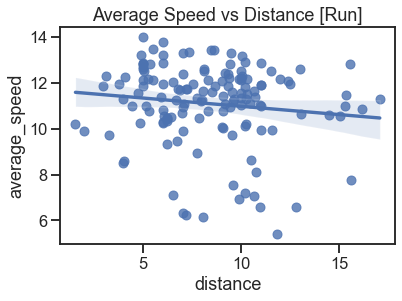

In [17]:
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = runs).set_title("Average Speed vs Distance [Run]");
#Units are km per hour!

array([<AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>,
       <AxesSubplot:xlabel='start_date_local'>], dtype=object)

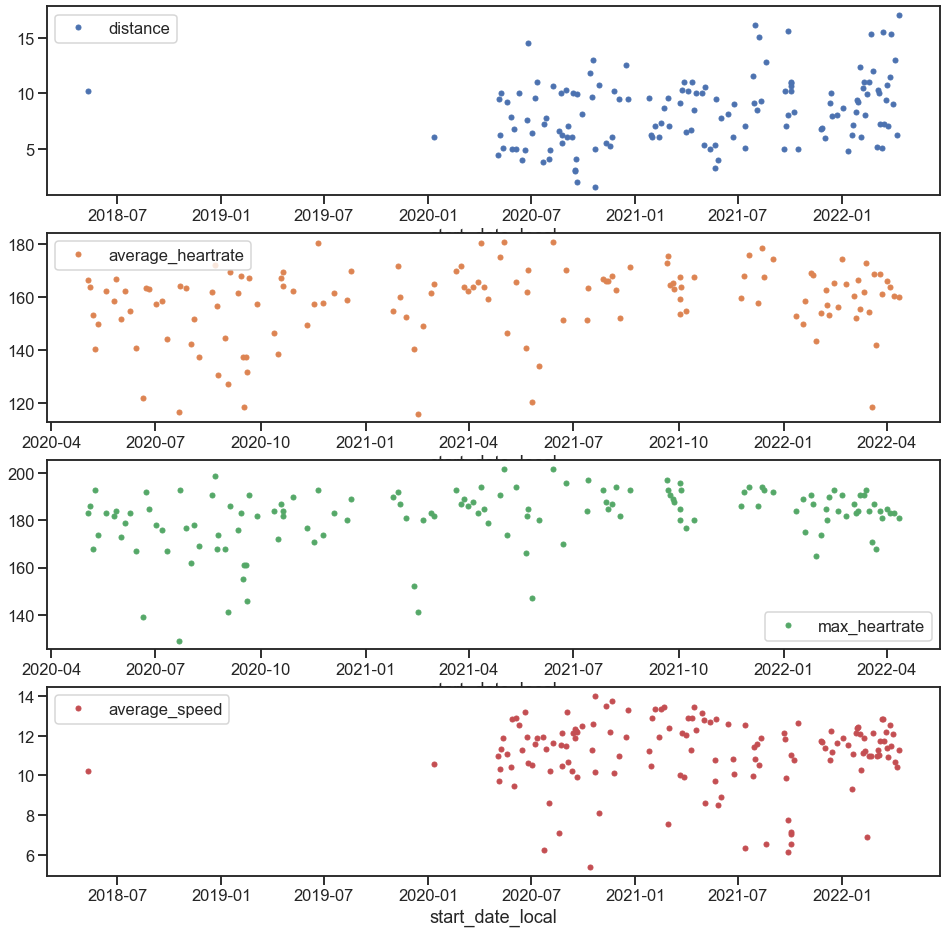

In [18]:
runs.plot(x='start_date_local' ,y=['distance','average_heartrate','max_heartrate','average_speed'],subplots=True,
                           sharex=False,
                           figsize=(16,16),
                           linestyle='none',
                           marker='o',
                           markersize=5,
                          )

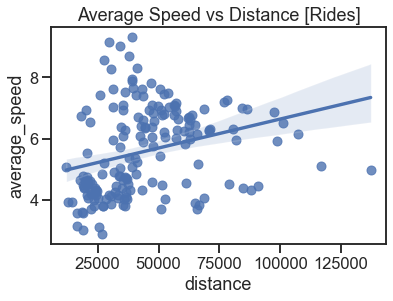

In [19]:
rides = activities.loc[activities['type'] == 'Ride']
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = rides).set_title("Average Speed vs Distance [Rides]");


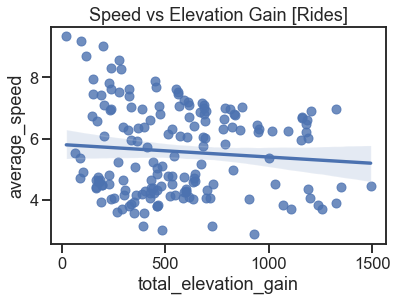

In [20]:
rides_filtered = rides.loc[(rides['total_elevation_gain'] < 1500)]
sns.regplot(x='total_elevation_gain', y = 'average_speed', data = rides_filtered).set_title("Speed vs Elevation Gain [Rides]");


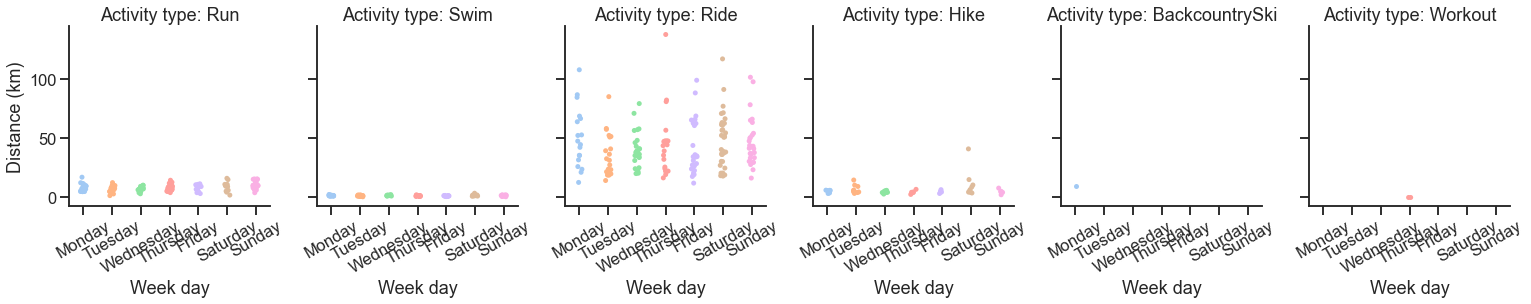

In [21]:
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]
g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=activities, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')
(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [22]:
#Activity number we want to plot in the map
activity_number=0

latlon=polyline.decode(activities['map.summary_polyline'][activity_number])

In [23]:
mapit = None
for coord in latlon:
    mapit = folium.Map( location=[ coord[0], coord[1] ] )

folium.PolyLine(latlon,
                color='red',
                weight=3,
                opacity=0.8).add_to(mapit)

mapit.save( 'map.html')

mapit

### Get the maps of the routes
https://developers.google.com/maps/documentation/utilities/polylineutility